In [3]:
!mkdir p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d crawford/emnist

100% 1.24G/1.24G [00:33<00:00, 39.4MB/s]
100% 1.24G/1.24G [00:33<00:00, 39.7MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emnist.zip','r')
zip_ref.extractall('/content/emnist/')
zip_ref.close()

In [6]:
#import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Input
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [119]:
def data_ingestion():
  '''
  ingesting the data of mnist from pip

  Args:
    Null
  Returns:
    train_data,
    test_data
  '''
  train_images_file = "/content/emnist/emnist_source_files/emnist-letters-train-images-idx3-ubyte"
  train_labels_file = "/content/emnist/emnist_source_files/emnist-letters-train-labels-idx1-ubyte"
  test_images_file = "/content/emnist/emnist_source_files/emnist-letters-test-images-idx3-ubyte"
  test_labels_file = "/content/emnist/emnist_source_files/emnist-letters-test-labels-idx1-ubyte"

  with open(train_images_file, 'rb') as f:
      train_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1,28,28,1)

  with open(train_labels_file, 'rb') as f:
      train_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

  with open(test_images_file, 'rb') as f:
      test_images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1,28,28,1)

  with open(test_labels_file, 'rb') as f:
      test_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)

  train_images = np.array([convert_image(img) for img in train_images])
  test_images = np.array([convert_image(img) for img in test_images])

  return train_images,train_labels,test_images,test_labels

In [120]:
train_images, train_labels, test_images, test_labels = data_ingestion()

In [121]:
def data_visualization(train_images,train_labels,test_labels,num_samples=5):

  '''
  function where emnist data is visualized
  '''
  print("shape of image",train_images[0].shape)
  print("No of train_samples",len(train_labels))
  print("No of test_samples", len(test_labels))
  print("Number of labels in the dataset is :", len(np.unique(train_labels)))

  plt.figure(figsize=(10, 5))
  for i in range(num_samples):
      plt.subplot(2, num_samples, i+1)
      plt.imshow(train_images[i], cmap='gray')
      plt.title(chr(train_labels[i] + 96))
      plt.axis('off')
  plt.show()

  plt.figure(figsize=(10,8))
  sns.countplot(x=train_labels)
  plt.title("Distribution of letters in dataset")
  plt.show()
  return

shape of image (28, 28)
No of train_samples 124800
No of test_samples 20800
Number of labels in the dataset is : 26


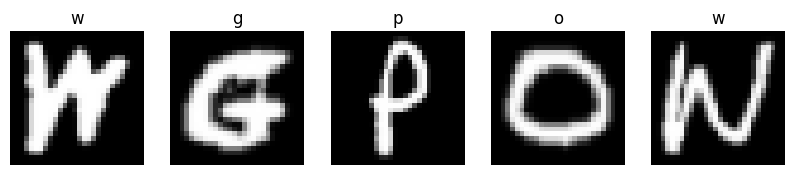

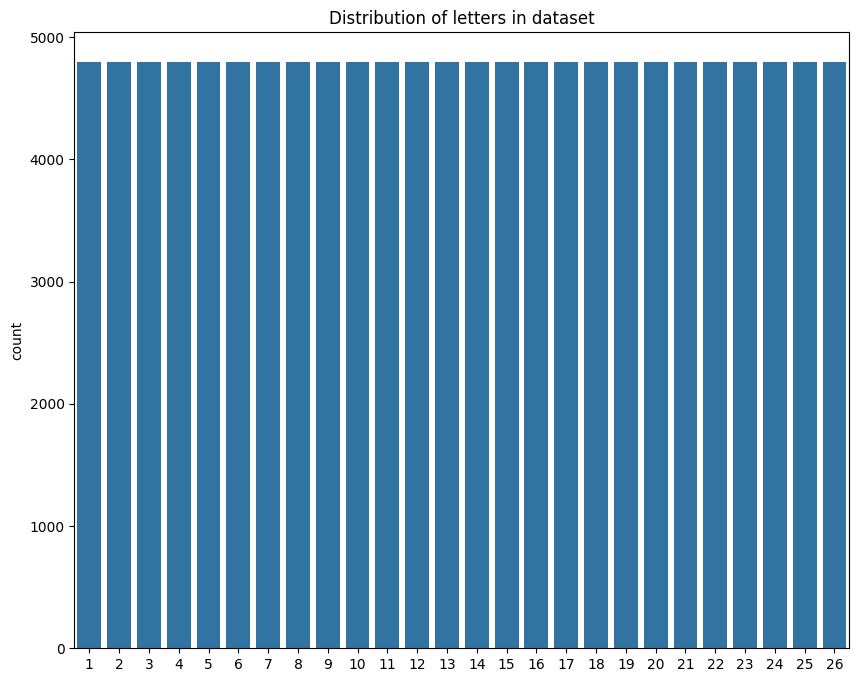

In [122]:
data_visualization(train_images,train_labels,test_labels)

In [118]:
import cv2

def convert_image(image):
    # Rotate the image clockwise by 90 degrees
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # Flip the rotated image horizontally
    flipped_image = cv2.flip(rotated_image, 1)
    return flipped_image

In [123]:
def data_preprocessing(train_images,test_images,train_labels,test_labels):

  '''
  function to preprocess the images ready to be used for training
  '''
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  train_labels = to_categorical(train_labels)
  test_labels = to_categorical(test_labels)

  return train_images,test_images,train_labels,test_labels

In [124]:
train_images,test_images,train_labels,test_labels = data_preprocessing(train_images,test_images,train_labels,test_labels)

In [125]:
def model_architecture():

  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(27, activation="softmax"))

  return model

In [126]:
model = model_architecture()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                      

In [127]:
def training_model(model,X_train,y_train,X_test,y_test):

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
  return history

In [128]:
history = training_model(model,train_images,train_labels,test_images,test_labels)

Epoch 1/10
3900/3900 [==============================] - 29s 7ms/step - loss: 0.5465 - accuracy: 0.8312 - val_loss: 0.2585 - val_accuracy: 0.9176
Epoch 2/10
3900/3900 [==============================] - 28s 7ms/step - loss: 0.2706 - accuracy: 0.9149 - val_loss: 0.2301 - val_accuracy: 0.9257
Epoch 3/10
3900/3900 [==============================] - 23s 6ms/step - loss: 0.2292 - accuracy: 0.9261 - val_loss: 0.2270 - val_accuracy: 0.9283
Epoch 4/10
3900/3900 [==============================] - 24s 6ms/step - loss: 0.1974 - accuracy: 0.9347 - val_loss: 0.2159 - val_accuracy: 0.9334
Epoch 5/10
3900/3900 [==============================] - 28s 7ms/step - loss: 0.1779 - accuracy: 0.9412 - val_loss: 0.2258 - val_accuracy: 0.9287
Epoch 6/10
3900/3900 [==============================] - 23s 6ms/step - loss: 0.1649 - accuracy: 0.9433 - val_loss: 0.2292 - val_accuracy: 0.9362
Epoch 7/10
3900/3900 [==============================] - 24s 6ms/step - loss: 0.1540 - accuracy: 0.9473 - val_loss: 0.2257 - val_ac

In [129]:
def model_evaluation(model,X_test,y_test):
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')
  return

In [130]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

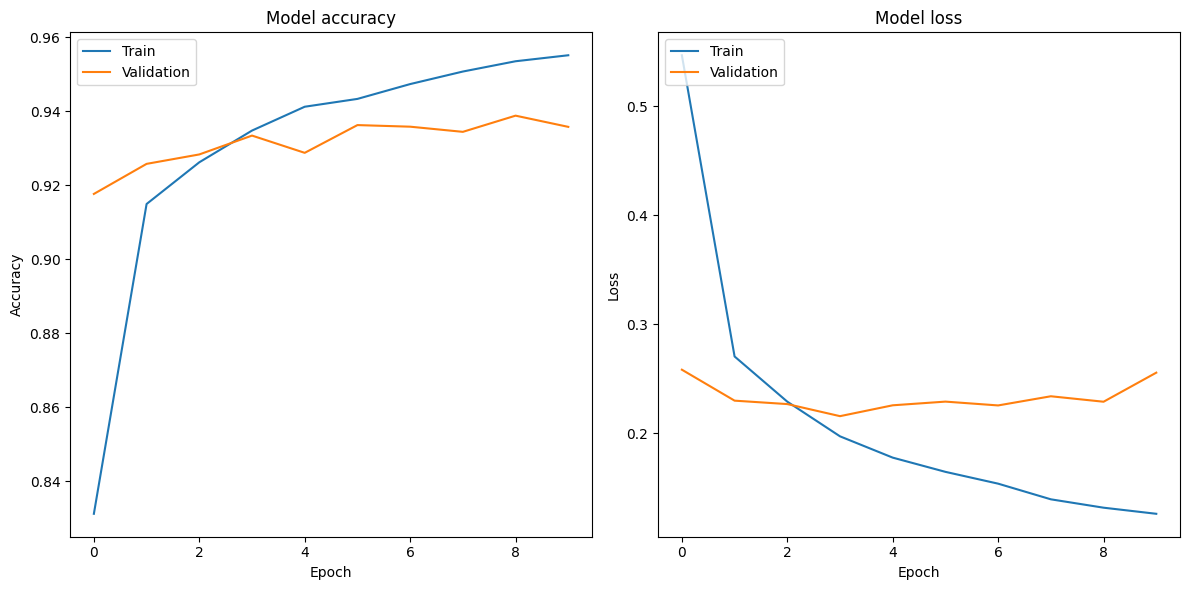

In [131]:
plot_history(history)

In [132]:
model_evaluation(model,test_images,test_labels)

650/650 [==============================] - 3s 4ms/step - loss: 0.2557 - accuracy: 0.9357
Test accuracy: 0.9357211589813232


In [138]:
def testing_model(model,X_train):
  arr = [" ","A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]

  # Change the index to use a different image for prediction
  image_index = 6534
  img = X_train[image_index]
  img = np.expand_dims(img, axis=0)  # Add batch dimension
#   img = img.reshape((1, 28, 28, 1))  # Reshape to match model input shape

  # Make prediction
  prediction = model.predict(img)
  predicted_label = np.argmax(prediction)

  plt.imshow(X_train[image_index], cmap="gray")
  plt.title(f"Prediction: {arr[predicted_label]}")
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 73ms/step


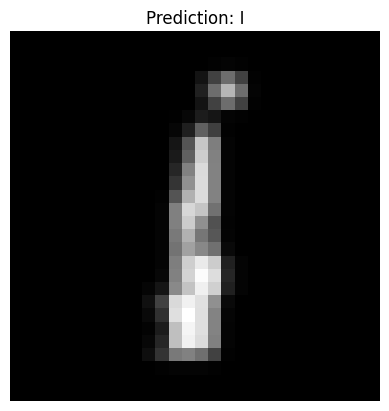

In [139]:
testing_model(model,test_images)

In [135]:
model.save("letters_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
